In [1]:
import sys
import os
import anndata as ad
import pandas as pd
import scanpy as sc
import re
import numpy as np
import seaborn as sns; sns.set(color_codes=True)
import scimap as sm  
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import pearsonr
import scipy.stats as stats

os.chdir("C:/Users/tav9/Dropbox (HMS)/PCA_phaseII/cycif_analysis_materials/data")
import napari

Running SCIMAP  2.1.0


In [19]:
df = pd.read_csv(r"C:\Users\tav9\HMS Dropbox\Tuulia Vallius\2024-Vallius-Novikov-Shi-Melanoma_PCA\data\GeoMX\entropy_GeoMX_immune_mapping.csv")

In [21]:
df['immune response'] = df['immune response'].replace('absent', 'no immune')

In [20]:
df

,ROI,entropy,immune response
0,'LSP13135_026',high,brisk
1,'LSP13140_001',high,non-brisk
2,'LSP13140_038',high,non-brisk
3,'LSP13140_043',high,non-brisk
4,'LSP13145_059',high,brisk
5,'LSP13150_002',high,no immune
6,'LSP13150_004',high,brisk
7,'LSP13150_018',high,no immune
8,'LSP13155_024',high,no immune
9,'LSP13155_025',high,no immune



Raw Counts (for N= labels):
immune response  brisk  no immune  non-brisk
entropy                                     
high                 3          7         10
low                  2         13          5

Proportions within each entropy group:
immune response  brisk  no immune  non-brisk
entropy                                     
high              0.15       0.35       0.50
low               0.10       0.65       0.25


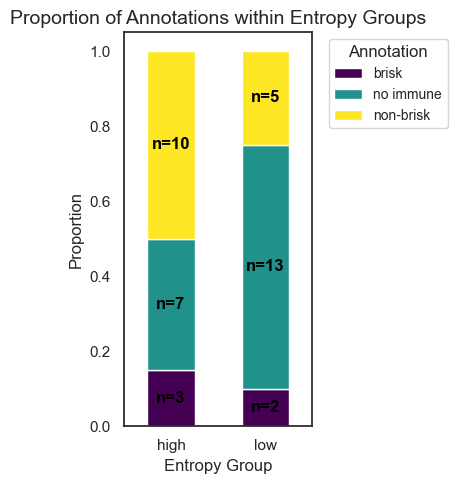

In [33]:
# 1. Calculate raw counts for each combination
# This is what 'n=' will represent
counts = df.groupby(['entropy', 'immune response']).size().unstack(fill_value=0)
print("\nRaw Counts (for N= labels):")
print(counts)

# 2. Calculate proportions (for bar heights)
proportions = counts.div(counts.sum(axis=1), axis=0)
print("\nProportions within each entropy group:")
print(proportions)

# 3. Plot the stacked bar chart of proportions
fig, ax = plt.subplots(figsize=(5, 5)) # Increased figure size for better label visibility

# Store the bar containers returned by plot to use with ax.bar_label
bar_containers = proportions.plot(kind='bar', stacked=True, ax=ax, cmap='viridis')

ax.set_title('Proportion of Annotations within Entropy Groups', fontsize=14)
ax.set_xlabel('Entropy Group', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Annotation', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# --- Add N= labels to the plot ---

# Iterate through each bar container (each 'annotation' type)
# `bar_containers` is an Axes object, and `.containers` gives a list of
# BarContainer objects, one for each stacked layer.
for container, annotation_type in zip(ax.containers, proportions.columns):
    # Iterate through each patch (individual bar segment) in the container
    for i, patch in enumerate(container.patches):
        # Get the height of the patch (which is the proportion)
        # and the x-position of the patch
        height = patch.get_height()
        width = patch.get_width()
        x = patch.get_x()
        y = patch.get_y() # This is the bottom of the segment

        # Get the corresponding raw count from the 'counts' DataFrame
        # The index `i` corresponds to the x-axis tick (entropy group)
        entropy_group = proportions.index[i]
        raw_count = counts.loc[entropy_group, annotation_type]

        # Only add label if the proportion is greater than 0 (or a small threshold)
        # and if the raw count is not zero, to avoid clutter
        if height > 0 and raw_count > 0:
            # Position the text in the middle of the bar segment
            # x-coordinate: center of the bar
            # y-coordinate: center of the segment
            ax.text(x + width / 2,
                    y + height / 2,
                    f'n={raw_count}',
                    ha='center', # Horizontal alignment: center
                    va='center', # Vertical alignment: center
                    color='black', # Text color for contrast
                    fontsize=12,
                    weight='bold' # Make text bold for visibility
                   )

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend and labels
plt.savefig("C:/Users/tav9/Dropbox (HMS)/test/test/immune_annotations_entropy_geomx_ROIs.pdf")
plt.show()

In [32]:
from scipy.stats import chi2_contingency

# --- Statistical Test: Chi-Squared Test of Independence ---

# 1. Create a contingency table (cross-tabulation of counts)
contingency_table = pd.crosstab(df['entropy'], df['immune response'])
print("\nContingency Table (Observed Frequencies):")
print(contingency_table)

# 2. Perform the Chi-Squared test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Squared Test Results:")
print(f"Chi-Square Statistic: {chi2:.3f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")



Contingency Table (Observed Frequencies):
immune response  brisk  no immune  non-brisk
entropy                                     
high                 3          7         10
low                  2         13          5

Chi-Squared Test Results:
Chi-Square Statistic: 3.667
P-value: 0.1599
Degrees of Freedom: 2



Proportions DataFrame after reordering annotations:
immune response  no immune  non-brisk  brisk
entropy                                     
high                  0.35       0.50   0.15
low                   0.65       0.25   0.10


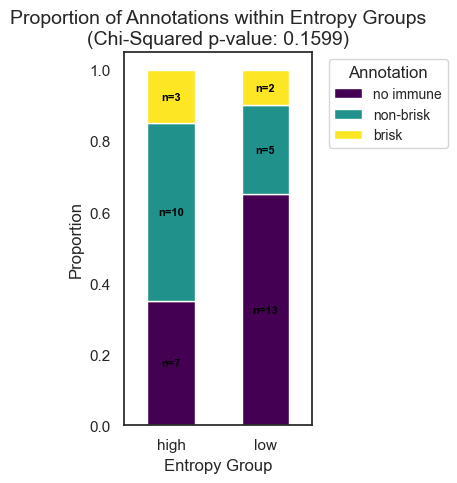

In [38]:
# --- Statistical Test: Chi-Squared Test of Independence ---
contingency_table = pd.crosstab(df['entropy'], df['immune response'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Calculate raw counts for N= labels
counts = contingency_table

# Calculate proportions (for bar heights)
proportions = counts.div(counts.sum(axis=1), axis=0)

# --- Reorder the annotations ---
# Define your desired order for the annotation categories
# Let's say you want 'NewTypeA' first, then 'Type4', then 'Type2', then 'Type3'
desired_annotation_order = ['no immune', 'non-brisk', 'brisk']

# Reindex the columns of the proportions DataFrame to the desired order
# This will ensure the plotting and legend follow this order
# Use .reindex with fill_value=0 in case some annotations are missing in the data
proportions = proportions.reindex(columns=desired_annotation_order, fill_value=0)

# Also reindex the counts DataFrame if you want the N= labels to correctly map
counts = counts.reindex(columns=desired_annotation_order, fill_value=0)

print("\nProportions DataFrame after reordering annotations:")
print(proportions)


# --- Plotting with N= labels and P-value ---

fig, ax = plt.subplots(figsize=(5, 5)) # Increased figure size

# Plot the reordered proportions
bar_containers = proportions.plot(kind='bar', stacked=True, ax=ax, cmap='viridis')

ax.set_title(f'Proportion of Annotations within Entropy Groups\n(Chi-Squared p-value: {p_value:.4f})', fontsize=14)
ax.set_xlabel('Entropy Group', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Annotation', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)


# Add N= labels to the plot
for container, annotation_type in zip(ax.containers, proportions.columns): # Use proportions.columns for correct order
    for i, patch in enumerate(container.patches):
        height = patch.get_height()
        width = patch.get_width()
        x = patch.get_x()
        y = patch.get_y()

        entropy_group = proportions.index[i]
        # Ensure raw_count is retrieved using the correct, reordered annotation_type
        raw_count = counts.loc[entropy_group, annotation_type]

        if height > 0 and raw_count > 0:
            ax.text(x + width / 2,
                    y + height / 2,
                    f'n={raw_count}',
                    ha='center',
                    va='center',
                    color='black',
                    fontsize=8,
                    weight='bold'
                   )

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("C:/Users/tav9/Dropbox (HMS)/test/test/immune_annotations_entropy_geomx_ROIs.pdf")
plt.show()